# Ejercicio 1 - Boston Housing

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import mglearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error


In [28]:
X, y = mglearn.datasets.load_extended_boston()

## EDA

In [29]:
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df = pd.concat([df_X, df_y], axis=1)
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
column_names = feature_names + ["Target"]
df = pd.DataFrame(df.values, columns=column_names)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,Target
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,...,0.059749,0.208015,0.018655,0.082503,0.287234,0.025759,1.000000,0.089680,0.008042,24.0
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,...,0.058064,0.104962,0.021462,0.306021,0.553191,0.113111,1.000000,0.204470,0.041808,21.6
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,...,0.058064,0.103885,0.006661,0.306021,0.547514,0.035109,0.979580,0.062814,0.004028,34.7
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,...,0.043345,0.066412,0.002230,0.421118,0.645222,0.021667,0.988585,0.033197,0.001115,33.4
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,...,0.043345,0.066794,0.006635,0.421118,0.648936,0.064464,1.000000,0.099338,0.009868,36.2


In [30]:
df['Target'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: Target, dtype: float64

## Análisis de variables categóricas

Observamos en las tablas anteriores información acerca de nuestra base de datos. Primero, vemos que estamos tratando con una base que contiene solo variables numéricas, las cuales indican alguna característica del *Boston Housing*. Además, solo conocemos la característica del "price", que es nuestra variable objetivo en el modelo de regresión lineal.

Asimismo, al continuar con el análisis, vemos que tenemos un total de 506 datos, donde, a simple vista, observamos que la mayoría de los valores tienen un máximo de "1" y un mínimo de "0". También, analizamos cómo se distribuyen en sus cuartiles y la media de cada una de estas variables.

## Análisis de datos NA'S

In [31]:
df.isnull().sum()

feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
              ..
feature_100    0
feature_101    0
feature_102    0
feature_103    0
Target         0
Length: 105, dtype: int64

Observamos que no existen datos NA en el DataFrame y, además, todas sus columnas tienen la misma cantidad de datos.

## Grafica de variable objectivo

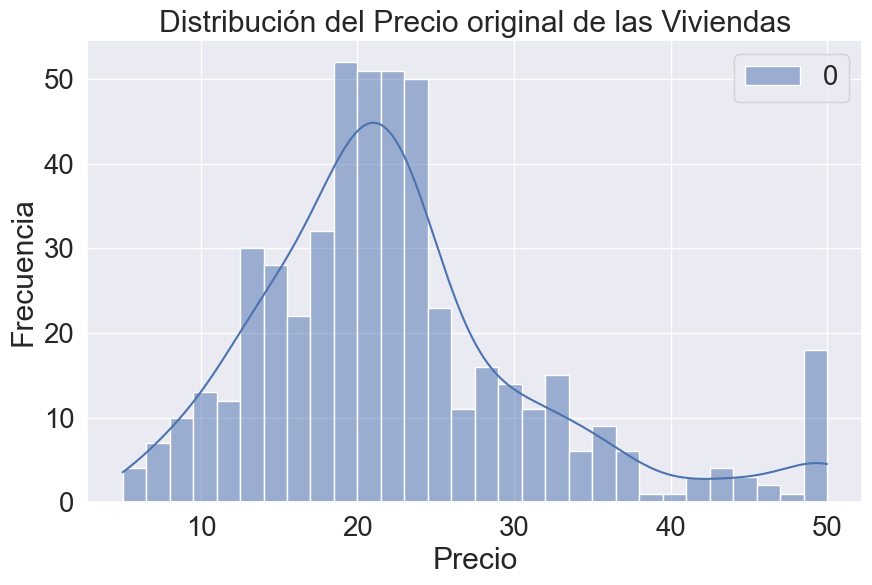

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df_y, bins=30, kde=True)
plt.title('Distribución del Precio original de las Viviendas')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

## Análisis de la gráfica

La gráfica muestra en el eje x el precio de las viviendas y en el eje y la frecuencia, es decir, la cantidad de viviendas que se encuentran en cada rango de precio.

La distribución parece ser aproximadamente normal o en forma de campana, con una cola más larga hacia la derecha. Esto indica que la mayoría de las viviendas tienen un precio concentrado. El punto más alto de la curva se encuentra alrededor de 20, lo que sugiere que el precio más común de las viviendas está cerca de este valor.

## Matriz de correlación

In [33]:
corr = df.iloc[: , 1:].corr()
corr.shape

(104, 104)

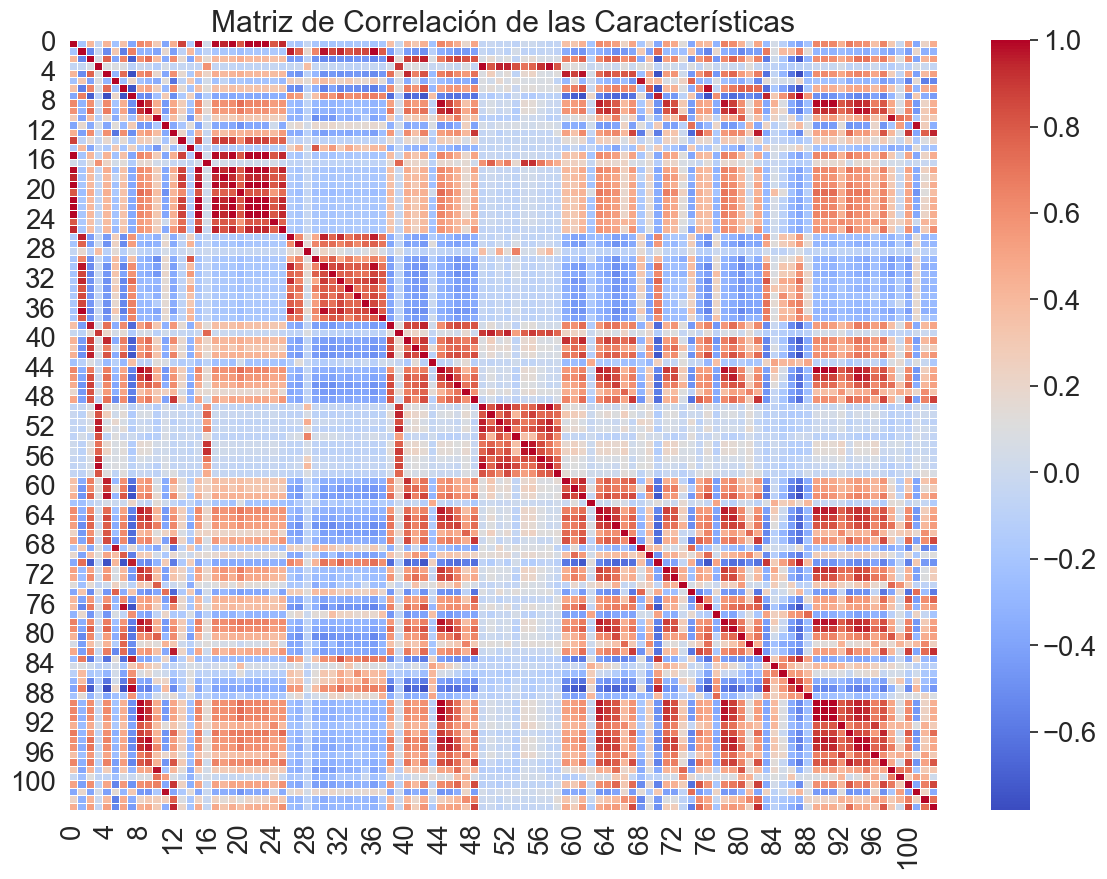

In [34]:
plt.figure(figsize=(14, 10))
correlation_matrix = df_X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de las Características')
plt.show()

**Análisis de la matriz de correlación**:

---

Antes de comenzar con el análisis, es importante señalar que estamos trabajando con una base de datos que tiene 104 variables, lo cual es una cantidad moderada. Realizar una correlación completa es complejo, pero intentaremos un análisis general.

Observamos, en primer lugar, que la matriz se divide en zonas con alta y baja correlación. Por ejemplo, en las columnas de 0 a 12, la mayoría de las combinaciones muestran una buena correlación. Asimismo, otra zona destacada es entre las columnas 44 y 48, donde se evidencia un buen comportamiento de correlación con algunas variables. Además, existen áreas con correlación muy baja, como entre las columnas 26 y 37, y entre las columnas 49 y 59.



### Analisis de multicolinealidad

Para el analisis de la multicolinealidad tendremos en cuenta
$$VIF = \frac{1}{1-R^2}$$

+ Un valor VIF de 1: Sin multicolinealidad (variable perfectamente independiente).

+ Un valor VIF entre 1 y 5: Multicolinealidad baja a moderada (no se considera problemática).

+ Un valor VIF entre 5 y 10: Multicolinealidad moderada a alta (considerada problemática).

+ Un valor VIF superior a 10: Multicolinealidad alta (preocupación grave, requiere medidas).

$creditos \text{ } a \text{ } Profesor: \text{ } Lihki \text{ } Rubio \text{ } por \text{ } por \text{ } la \text{ } informacion $

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [36]:
def VIF_calculation(X):
    VIF = pd.DataFrame()
    VIF["variable"] = X.columns
    VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    VIF = VIF.sort_values('VIF', ascending=False).reset_index(drop = True)
    return(VIF)

In [37]:
def delete_multicollinearity(df, target_name, VIF_threshold):
  X = df.drop(target_name, axis=1)
  VIF_mat = VIF_calculation(X)
  n_VIF = VIF_mat["VIF"][0]
  if (n_VIF <= VIF_threshold):
    print("There is no multicollinearity!")
  else:
    while (n_VIF > VIF_threshold):
      X = X.drop(VIF_mat["variable"][0], axis=1)
      VIF_mat = VIF_calculation(X)
      n_VIF = VIF_mat["VIF"][0]
  display(VIF_mat)
  return X

In [38]:
'''df_copy = df.copy( )
df_copy = delete_multicollinearity(df_copy, "Target", 10)'''
df_copy = pd.read_parquet('documentos_ejercicio2.1\\df_copy.parquet')

In [39]:
df_copy.to_parquet('documentos_ejercicio2.1\\df_copy.parquet', index=False)


In [40]:
df_copy.head()

,feature_13,feature_14,feature_16,feature_20,feature_24,feature_26,feature_27,feature_28,feature_29,feature_33,...,feature_51,feature_54,feature_58,feature_59,feature_62,feature_68,feature_76,feature_83,feature_92,feature_103
0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0324,0.012207,0.0,0.056667,0.0,...,0.0,0.0,0.0,0.099108,0.084749,0.333512,0.411659,0.072470,0.000000,0.008042
1,5.565944e-08,0.0,0.0,0.000082,0.000236,0.0000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.029873,0.060314,0.300301,0.612617,0.121774,0.043478,0.041808
2,5.555343e-08,0.0,0.0,0.000082,0.000233,0.0000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.029873,0.060314,0.482172,0.359259,0.121774,0.043032,0.004028
3,8.572933e-08,0.0,0.0,0.000131,0.000291,0.0000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.022562,0.067374,0.433695,0.195198,0.201192,0.086459,0.001115
4,4.971238e-07,0.0,0.0,0.000316,0.000705,0.0000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.022562,0.067374,0.472113,0.279123,0.201192,0.086957,0.009868


**Resultados del análisis de multicolinealidad**:

En las tablas anteriores, identificamos las variables con alta, media y baja multicolinealidad. Estas variables se guardarán en un DataFrame, que utilizaremos posteriormente para generar una matriz de correlación.

### Matriz de correlación
luego de realizar el VIF


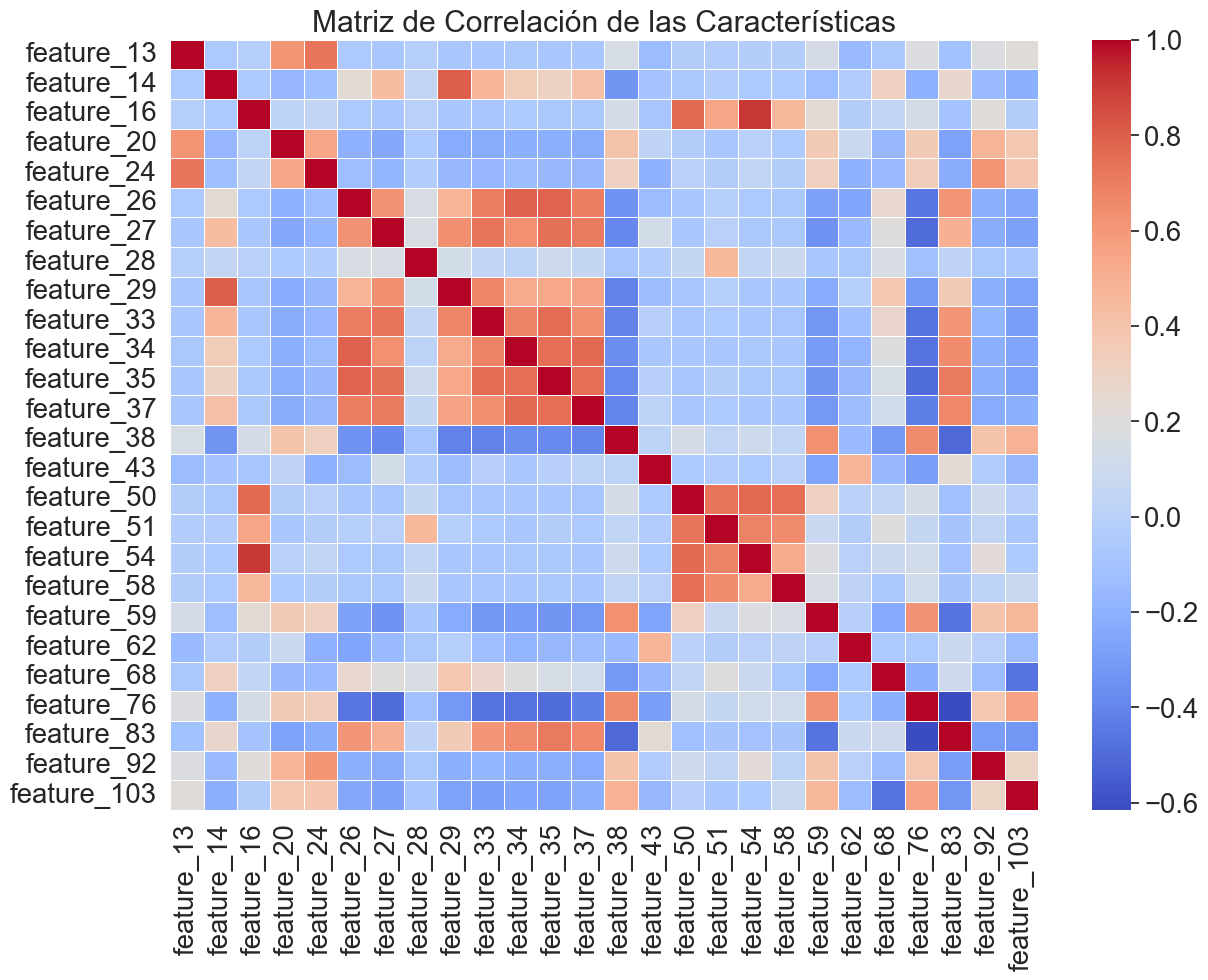

In [41]:
plt.figure(figsize=(14, 10))
correlation_matrix = df_copy.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de las Características')
plt.show()


Luego del análisis de multicolinealidad, observamos una correlación negativa mayor y una sección con correlación media entre las variables feature 26 y  feature 37. Además, se destaca una fuerte correlación entre las mismas variables.


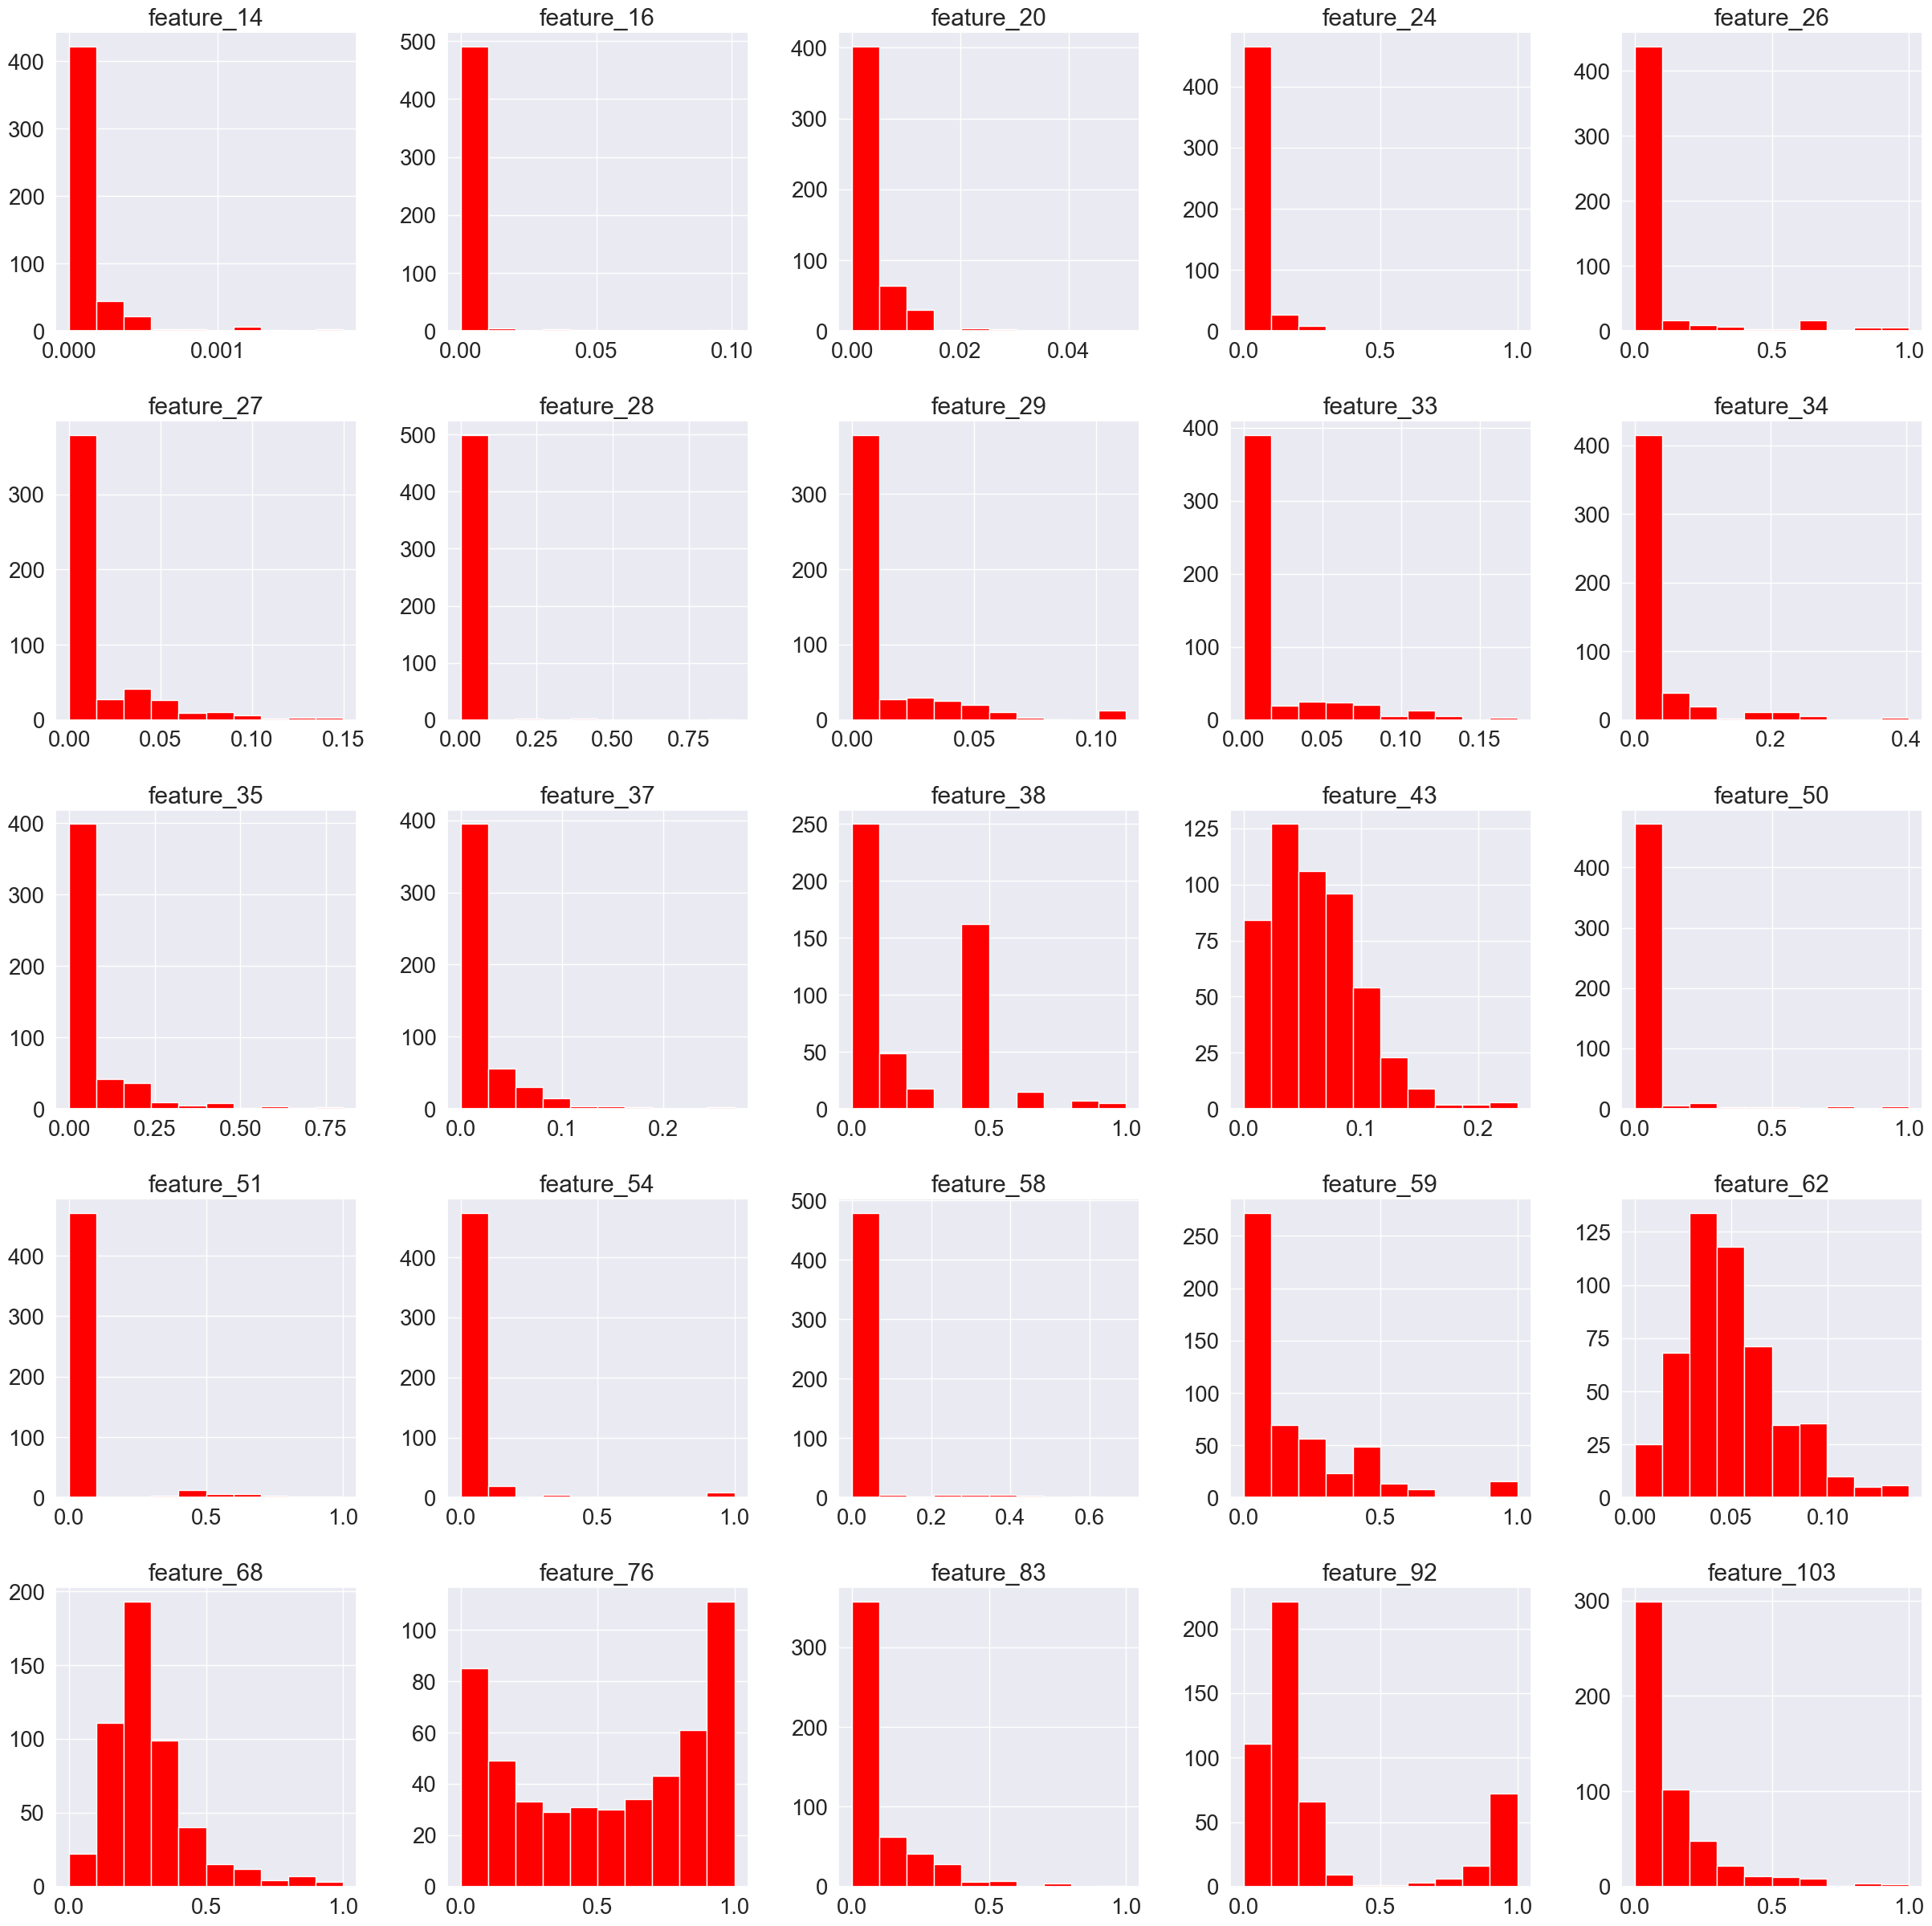

In [42]:
sns.set(font_scale=1.8)
df_copy.iloc[: , 1:].hist(figsize = (30,30), color = 'red');

En estas gráficas, observamos cada variable que quedó después de realizar el VIF. Podemos analizar su comportamiento y cómo se distribuyen. Las variables 62 y 68 parecen tener un comportamiento normal.

### Pipeline y Gridsearchcv()

In [43]:
scoring = {
    'R²': 'r2',
    'MSE': make_scorer(mean_squared_error, greater_is_better=False)
}

In [44]:
target = df['Target']
data = df.drop(columns=['Target'])
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1)
print("Size of training set: {} size of validation set: {} size of test set: {}\n".
      format(X_train.shape[0], X_test.shape[0], X_test.shape[0]))

Size of training set: 379 size of validation set: 127 size of test set: 127



## Análisis de la variable objetivo
en train y en test

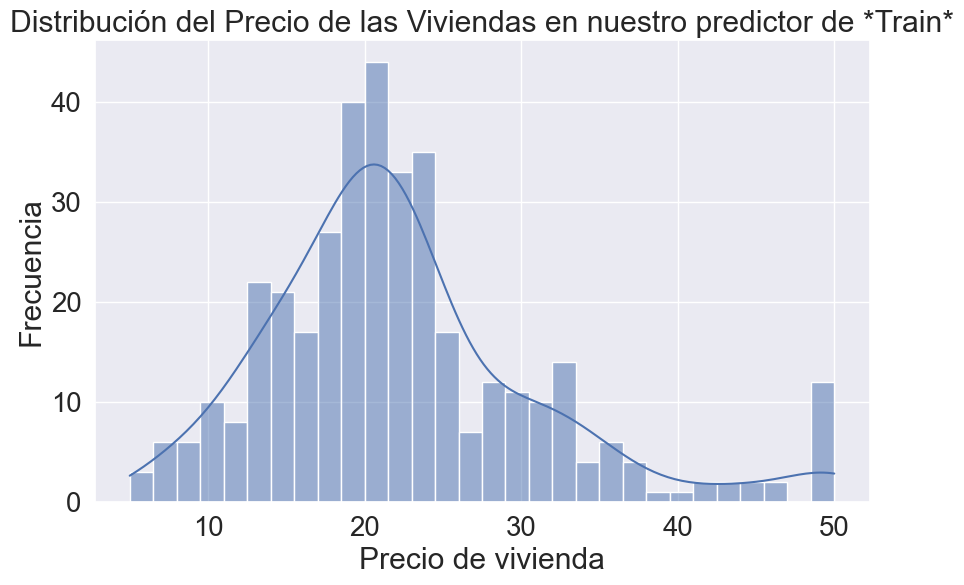

count    379.000000
mean      22.344591
std        8.920931
min        5.000000
25%       17.100000
50%       20.800000
75%       25.000000
max       50.000000
Name: Target, dtype: float64


In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Distribución del Precio de las Viviendas en nuestro predictor de *Train*')
plt.xlabel('Precio de vivienda')
plt.ylabel('Frecuencia')
plt.show()

print(y_train.describe())

En esta gráfica se observa la frecuencia de nuestra variable objetivo respecto al precio de la vivienda. Comparada con nuestra gráfica original, parece mantener una distribución similar, aunque se notan diferencias en algunos picos que son más bajos que los originales. Además, observamos la cantidad de datos que posee esta variable de **y_TRAIN**, así como su media, desviación, valor mínimo y máximo.

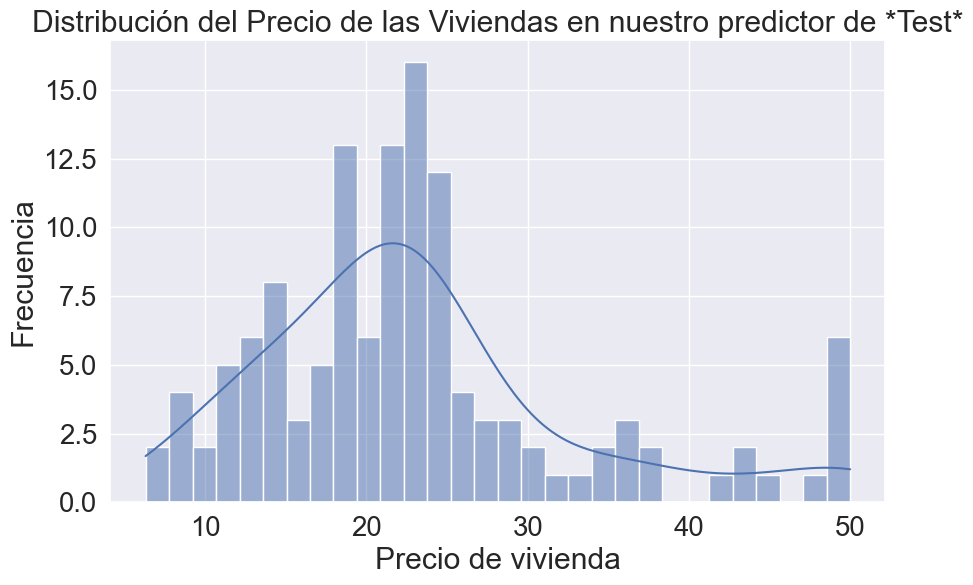

count    127.000000
mean      23.094488
std        9.992230
min        6.300000
25%       16.650000
50%       22.000000
75%       25.150000
max       50.000000
Name: Target, dtype: float64


In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=30, kde=True)
plt.title('Distribución del Precio de las Viviendas en nuestro predictor de *Test*')
plt.xlabel('Precio de vivienda')
plt.ylabel('Frecuencia')
plt.show()

print(y_test.describe())


En esta gráfica, apreciamos que estamos tratando con una cantidad de datos menor en comparación con **Y_TRAIN** y que siguen una distribución similar a la original. Sin embargo, se nota que hay más barras más bajas que en la gráfica anterior, como cuando el precio está en 40, donde no se observa ninguna barra, notándose estos cambios. Además, la línea de distribución es menor en el pico entre 15-30 en el precio de la vivienda. También vemos que esta variable tiene 127 datos, una desviación de 9.9, siendo mayor que la de **y_train**, y teniendo un valor mínimo más alto y un máximo igual al anterior.

### KNN

In [47]:
param_grid_1 = {'knn__n_neighbors': range(1, 20)}
KNN = KNeighborsRegressor()
pipe = Pipeline([ ('scaler', MinMaxScaler()), ('knn', KNN) ])
grid_knn = GridSearchCV(pipe, param_grid_1, cv=5, scoring = scoring, refit='R²')
grid_knn.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid_knn.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_knn.best_score_))
print("Test-set score: {:.2f}".format(grid_knn.score(X_test, y_test)))

Best params:
{'knn__n_neighbors': 2}

Best cross-validation score: 0.73
Test-set score: 0.79


### Linear Regression

In [48]:
param_grid_2 = {
    'regressor__fit_intercept': [True, False],
    'regressor__copy_X': [True, False],
    'regressor__positive': [True, False]
}

linear = LinearRegression()
pipe = Pipeline([('scaler', MinMaxScaler()), ('regressor',linear )])
grid_lin = GridSearchCV(pipe, param_grid_2, cv=5, scoring=scoring, refit='R²')
grid_lin.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid_lin.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_lin.best_score_))
print("Test-set score: {:.2f}".format(grid_lin.score(X_test, y_test)))

Best params:
{'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__positive': False}

Best cross-validation score: 0.72
Test-set score: 0.90


In [49]:
knn_y_pred = grid_knn.predict(X_test)
lin_y_pred = grid_lin.predict(X_test)

In [50]:
data = {
    'Modelo': ['K-NN', 'Linear Regression'],
    'MAPE': [
        mean_absolute_percentage_error(y_test, knn_y_pred),
        mean_absolute_percentage_error(y_test, lin_y_pred)
    ],
    'MAE': [
        mean_absolute_error(y_test, knn_y_pred),
        mean_absolute_error(y_test, lin_y_pred)
    ],
    'RMSE': [
        mean_squared_error(y_test, knn_y_pred, squared=False),  # RMSE = Raíz del MSE
        mean_squared_error(y_test, lin_y_pred, squared=False)
    ],
    'MSE': [
        mean_squared_error(y_test, knn_y_pred),
        mean_squared_error(y_test, lin_y_pred)
    ],
    'R²': [
        r2_score(y_test, knn_y_pred),
        r2_score(y_test, lin_y_pred)
    ]
}
import pandas as pd
df = pd.DataFrame(data)
df.head()

,Modelo,MAPE,MAE,RMSE,MSE,R²
0,K-NN,0.150104,3.301969,4.537002,20.584390,0.792200
1,Linear Regression,0.130571,2.473152,3.206455,10.281355,0.896209


### Pipeline y gridsearch iterativo

In [51]:
def func_cross_val_score(model, X_train, y_train, kf=None, scaler=None, train_list=[], test_list=[]):
    r2_scores = []
    mae_scores = []
    rmse_scores = []
    mse_scores = []
    if kf is None:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if scaler is None:
        scaler = MinMaxScaler()
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred)
        mae = mean_absolute_error(y_val_fold, y_pred)
        rmse = mean_squared_error(y_val_fold, y_pred, squared=False)
        mse = mean_squared_error(y_val_fold, y_pred)
        train_list.append(model.score(X_train_fold, y_train_fold))
        test_list.append(model.score(X_val_fold, y_val_fold))
        r2_scores.append(r2)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        mse_scores.append(mse)

    return np.mean(r2_scores), np.mean(mae_scores), np.mean(rmse_scores), np.mean(mse_scores), np.mean(train_list), np.mean(test_list)
recalls = []
k_recall = [[],[]]
results = [[],[]]
scores1 = [0,0,0]
best_r2 = -np.inf
best_k = None
range_neighbors = range(1, 21)

for k in range_neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    r2, mae, rmse, mse, score_train, score_test = func_cross_val_score(model=knn, X_train=X_train, y_train=y_train)
    if r2 > best_r2:
        best_r2 = r2
        scores1[0] = mae
        scores1[1] = rmse
        scores1[2] = mse
        best_k = k
    k_recall[0].append(k)
    k_recall[1].append(r2)
    results[0].append(score_train)
    results[1].append(score_test)
    recalls.append(r2)

print(f'Best R²: {best_r2}, Best k: {best_k}')
save = best_r2


Best R²: 0.7386381425411995, Best k: 2


In [52]:
recalls = []
k_recall = [[],[]]
results = [[],[]]
scores2 = [0,0,0]
best_r2 = -np.inf
lr = LinearRegression()
r2, mae, rmse, mse, score_train, score_test = func_cross_val_score(model=lr, X_train=X_train, y_train=y_train)
if r2 > best_r2:
    best_r2 = r2
    scores2[0] = mae
    scores2[1] = rmse
    scores2[2] = mse
k_recall[0].append(1)
k_recall[1].append(r2)
results[0].append(score_train)
results[1].append(score_test)
recalls.append(r2)

In [53]:
print(f'Best R²: {best_r2}, Best alpha: {best_k}')

Best R²: 0.7402439918242878, Best alpha: 2


In [54]:
data = {
    'Modelo': ['K-NN', 'Linear Regression'],
    'MAE': [
        scores1[0],
        scores2[0]
    ],
    'RMSE': [
        scores1[1],  # RMSE = Raíz del MSE
        scores2[1]
    ],
    'MSE': [
        scores1[2],
        scores2[2]
    ],
    'R²': [
        save,
        best_r2
    ]
}
import pandas as pd
df = pd.DataFrame(data)
df.head()

,Modelo,MAE,RMSE,MSE,R²
0,K-NN,3.022828,4.477268,20.199874,0.738638
1,Linear Regression,2.976536,4.357679,19.473648,0.740244
